<a href="https://colab.research.google.com/github/kaicong12/CRNN-HandWriting-Recognition/blob/main/NewAuthorFromScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!mkdir -p words xml HTR_Using_CRNN/Model
!unzip -qq "/content/gdrive/MyDrive/Colab Notebooks/biased_ref.zip" -d "/content/biased_ref"
!unzip -qq "/content/gdrive/MyDrive/Colab Notebooks/Real_HandWriting.zip" -d "/content/Real_HandWriting"

In [5]:
import numpy as np
import cv2
import os
import os.path as osp
import glob
import pandas as pd
import string
import matplotlib.pyplot as plt
from datetime import datetime
import xml.etree.cElementTree as et

from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from keras.models import Model
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Global Variables

In [6]:
# dataset related variables
MAX_LABEL_LEN = 0
CHAR_LIST = "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"
train_images = []
train_labels = []
train_input_length = []
train_label_length = []
train_original_text = []

valid_images = []
valid_labels = []
valid_input_length = []
valid_label_length = []
valid_original_text = []

inputs_length = []
labels_length = []


# model related variables
BATCH_SIZE = 8
EPOCHS = 30
E = str(EPOCHS)
OPTIMIZER_NAME = 'sgd'

# Build Training Set

In [7]:
def extract_from_biased_ref(directory):
    words = []
    label_files = glob.glob(f"{directory}/*.png")

    for label_filepath in label_files:
        text = osp.splitext(label_filepath.split("_")[-1])[0]
        
        words.append({
            'image_filepath': label_filepath,
            'text': text
        })
    
    return words

In [8]:
data = extract_from_biased_ref("/content/biased_ref/biased_ref")

In [9]:
data[0]

{'image_filepath': '/content/biased_ref/biased_ref/synthetic_biased_ref(10423)_tutoyer.png',
 'text': 'tutoyer'}

In [10]:
# string.ascii_letters + string.digits (Chars & Digits)
# or 
# "!\"#&'()*+,-./0123456789:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    for index, chara in enumerate(txt):
        dig_lst.append(CHAR_LIST.index(chara))
        
    return dig_lst

In [11]:
def process_image(img):
    """
    Converts image to shape (32, 128, 1) & normalize
    """
    w, h = img.shape
    
#     _, img = cv2.threshold(img, 
#                            128, 
#                            255, 
#                            cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Aspect Ratio Calculation
    new_w = 32
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h = img.shape
    
    img = img.astype('float32')
    
    # Converts each to (32, 128, 1)
    if w < 32:
        add_zeros = np.full((32-w, h), 255)
        img = np.concatenate((img, add_zeros))
        w, h = img.shape
    
    if h < 128:
        add_zeros = np.full((w, 128-h), 255)
        img = np.concatenate((img, add_zeros), axis=1)
        w, h = img.shape
        
    if h > 128 or w > 32:
        dim = (128,32)
        img = cv2.resize(img, dim)
    
    img = cv2.subtract(255, img)
    
    img = np.expand_dims(img, axis=2)
    
    # Normalize 
    cv2.normalize(img, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    return img

In [12]:
for index, word in enumerate(data):
    image_filepath = word['image_filepath']
    text = word['text']

    # processing on image
    img = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)

    try:
        img = process_image(img)
    except:
        raise Exception("Unable to process image")

    # processing on label
    try:
        label = encode_to_labels(text)
    except:
        raise Exception("Unable to process label")
    
    # added this line to prevent error from CTC computation
    if len(label) > 31:
      continue
    
    if index % 10 == 0:
        valid_images.append(img)
        valid_labels.append(label)
        valid_input_length.append(31)
        valid_label_length.append(len(text))
        valid_original_text.append(text)
    else:
        train_images.append(img)
        train_labels.append(label)
        train_input_length.append(31)
        train_label_length.append(len(text))
        train_original_text.append(text)
    
    if len(text) > MAX_LABEL_LEN:
        MAX_LABEL_LEN = len(text)

In [13]:
train_padded_labels = pad_sequences(train_labels, 
                      maxlen=MAX_LABEL_LEN, 
                      padding='post',
                      value=len(CHAR_LIST))

valid_padded_labels = pad_sequences(valid_labels, 
                      maxlen=MAX_LABEL_LEN, 
                      padding='post',
                      value=len(CHAR_LIST))

# Convert to numpy array.
train_images = np.asarray(train_images)
train_input_length = np.asarray(train_input_length)
train_label_length = np.asarray(train_label_length)

valid_images = np.asarray(valid_images)
valid_input_length = np.asarray(valid_input_length)
valid_label_length = np.asarray(valid_label_length)

In [14]:
train_images.shape, valid_images.shape

((27487, 32, 128, 1), (3055, 32, 128, 1))

# Model Building

In [ ]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))
 
# convolution layer with kernel size (3,3)
conv_1 = Conv2D(64, (3,3), activation = 'relu', padding='same')(inputs)
# poolig layer with kernel size (2,2)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(128, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)
 
conv_3 = Conv2D(256, (3,3), activation = 'relu', padding='same')(pool_2)
 
conv_4 = Conv2D(256, (3,3), activation = 'relu', padding='same')(conv_3)

# poolig layer with kernel size (2,1)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(512, (3,3), activation = 'relu', padding='same')(pool_4)

# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(512, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(512, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(squeezed)
blstm_2 = Bidirectional(LSTM(256, return_sequences=True, dropout = 0.2))(blstm_1)
 
outputs = Dense(len(CHAR_LIST)+1, activation = 'softmax')(blstm_2)

# model to be used at test time
act_model = Model(inputs, outputs)

# Loss Function

In [ ]:
the_labels = Input(name='the_labels', shape=[MAX_LABEL_LEN], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, the_labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, the_labels, input_length, label_length], outputs=loss_out)

In [ ]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = OPTIMIZER_NAME, metrics=['accuracy'])

now = datetime.now()
date_time = now.strftime("%m_%d_%Y_%H%M%S")
filepath=f"HTR_Using_CRNN/Model/{date_time}.hdf5"

# Callback to monitor val loss
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
earlystopping = EarlyStopping(patience=5, monitor='val_loss', min_delta=0, mode='min')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.001)

callbacks_list = [earlystopping, lr_scheduler, checkpoint]

In [ ]:
history = model.fit(x=[train_images, train_padded_labels, train_input_length, train_label_length],
                    y=np.zeros(len(train_images)),
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data=([valid_images, valid_padded_labels, valid_input_length, valid_label_length], [np.zeros(len(valid_images))]),
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/30

Epoch 1: val_loss improved from inf to 1.88526, saving model to HTR_Using_CRNN/Model/11_08_2022_142424.hdf5
3436/3436 - 110s - loss: 11.9197 - accuracy: 0.1233 - val_loss: 1.8853 - val_accuracy: 0.4052 - lr: 0.0100 - 110s/epoch - 32ms/step
Epoch 2/30

Epoch 2: val_loss improved from 1.88526 to 1.24761, saving model to HTR_Using_CRNN/Model/11_08_2022_142424.hdf5
3436/3436 - 88s - loss: 1.3201 - accuracy: 0.5805 - val_loss: 1.2476 - val_accuracy: 0.6412 - lr: 0.0100 - 88s/epoch - 26ms/step
Epoch 3/30

Epoch 3: val_loss improved from 1.24761 to 0.92643, saving model to HTR_Using_CRNN/Model/11_08_2022_142424.hdf5
3436/3436 - 90s - loss: 0.7685 - accuracy: 0.7409 - val_loss: 0.9264 - val_accuracy: 0.7532 - lr: 0.0100 - 90s/epoch - 26ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.92643
3436/3436 - 89s - loss: 0.5535 - accuracy: 0.8083 - val_loss: 0.9616 - val_accuracy: 0.7375 - lr: 0.0100 - 89s/epoch - 26ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.9

# Generate Test Set from author 10011

In [15]:
test_images = []
test_labels = []
test_input_length = []
test_label_length = []
test_original_text = []

def extract_real_handwriting(label_dir):
    words = []
    label_files = glob.glob(f"{label_dir}/*.txt")

    for label_filepath in label_files:
      text_id = osp.splitext(osp.basename(label_filepath))[0]
      
      # read in the txt file
      label = None
      with open(label_filepath, encoding="utf-8") as f:
        label = f.read().strip()
      
      # check if label is read in correctly
      assert label is not None, "Unable to detect label"
      
      image_filepath = osp.join(label_dir, f"{text_id}.png")
      if not osp.isfile(image_filepath):
          raise Exception(f"{image_filepath} not found.")

      words.append({
          'id': text_id,
          'image_filepath': image_filepath,
          'text': label
      })
    
    return words

In [16]:
test_data = extract_real_handwriting("/content/Real_HandWriting/Real_HandWriting")

In [17]:
for index, word in enumerate(test_data):
    image_filepath = word['image_filepath']
    text = word['text']

    # processing on image
    img = cv2.imread(image_filepath, cv2.IMREAD_GRAYSCALE)

    try:
        img = process_image(img)
    except:
        raise Exception("Unable to process image")

    # processing on label
    try:
        label = encode_to_labels(text)
    except Exception as e:
        raise Exception("Unable to process label")
    
    # added this line to prevent error from CTC computation
    if len(label) > 31:
      continue
    
    test_images.append(img)
    test_labels.append(label)
    test_input_length.append(31)
    test_label_length.append(len(text))
    test_original_text.append(text)

In [18]:
test_padded_label = pad_sequences(test_labels, 
                             maxlen=MAX_LABEL_LEN, 
                             padding='post',
                             value=len(CHAR_LIST))

test_images = np.asarray(test_images)
test_input_length = np.asarray(test_input_length)
test_label_length = np.asarray(test_label_length)

In [19]:
test_images.shape

(282, 32, 128, 1)

# Benchmark - Character Error Rate

In [ ]:
def levenshtein_distance(s, t):
    dp = [[0 for i in range(len(t)+1)] for j in range(len(s)+1)]
    
    # fill in the border, can only be insert
    for i in range(1, len(dp)):
        dp[i][0] = i
    for j in range(1, len(dp[0])):
        dp[0][j] = j
    
    # s is vertical, t is horizontal
    for i in range(1, len(dp)):
        for j in range(1, len(dp[i])):
            if s[i-1] == t[j-1]:
                dp[i][j] = dp[i-1][j-1]
            else:
                dp[i][j] = 1 + min(dp[i][j-1],        # Insert
                                   dp[i-1][j],        # Remove
                                   dp[i-1][j-1])      # Replace

    return dp[len(s)][len(t)]

In [ ]:
# predict outputs on test images
act_model.load_weights(filepath)
prediction = act_model.predict(test_images)

96/96 [==============================] - 2s 23ms/step


edit distance =  0
original_text =   namers
predicted text = namers

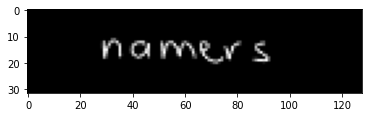



edit distance =  1
original_text =   thysanurous
predicted text = thysauurous

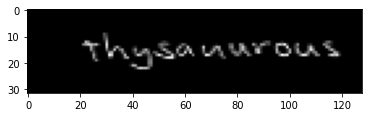



edit distance =  0
original_text =   methronic
predicted text = methronic

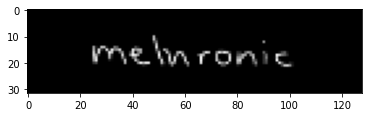



edit distance =  0
original_text =   redcaps
predicted text = redcaps

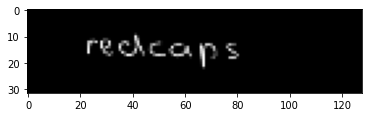



edit distance =  0
original_text =   madnep
predicted text = madnep

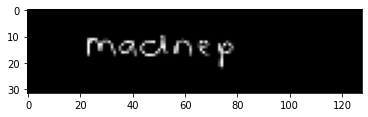



edit distance =  0
original_text =   tubuliporoid
predicted text = tubuliporoid

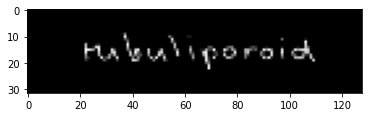



edit distance =  0
original_text =   postdigestive
predicted text = postdigestive

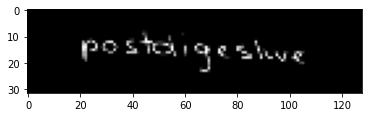



edit distance =  0
original_text =   undiamonded
predicted text = undiamonded

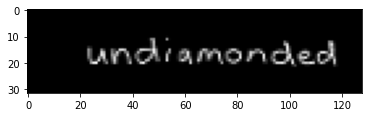



edit distance =  0
original_text =   silicochloroform
predicted text = silicochloroform

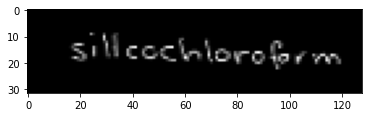



edit distance =  0
original_text =   parnel
predicted text = parnel

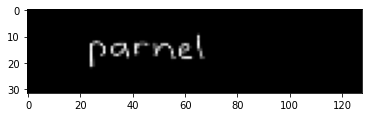



edit distance =  0
original_text =   stephanial
predicted text = stephanial

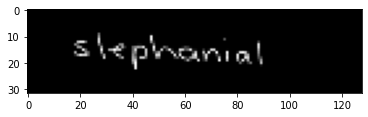



edit distance =  0
original_text =   jactivus
predicted text = jactivus

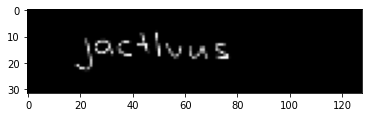



edit distance =  0
original_text =   refectionary
predicted text = refectionary

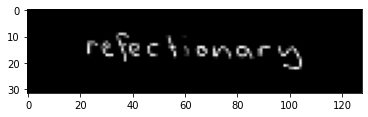



edit distance =  0
original_text =   begowned
predicted text = begowned

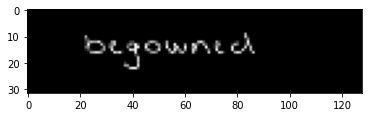



edit distance =  0
original_text =   preroute
predicted text = preroute

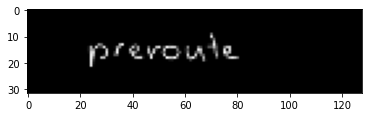



edit distance =  0
original_text =   atrede
predicted text = atrede

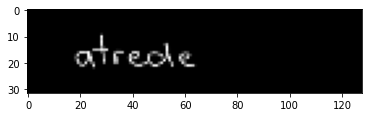



edit distance =  0
original_text =   decurrent
predicted text = decurrent

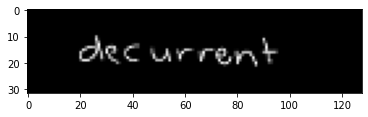



edit distance =  0
original_text =   bestud
predicted text = bestud

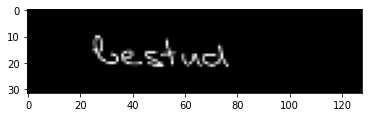



edit distance =  0
original_text =   rationalizer
predicted text = rationalizer

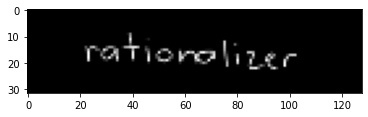



edit distance =  0
original_text =   dependancy
predicted text = dependancy

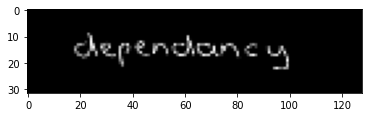



edit distance =  0
original_text =   calathiform
predicted text = calathiform

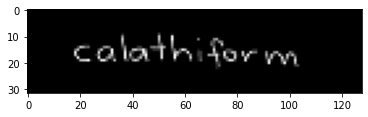



edit distance =  0
original_text =   isoleads
predicted text = isoleads

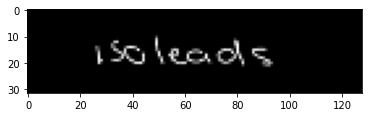



edit distance =  0
original_text =   coleopteron
predicted text = coleopteron

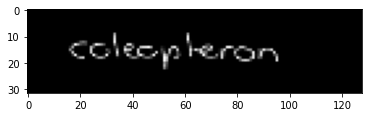



edit distance =  0
original_text =   oleraceae
predicted text = oleraceae

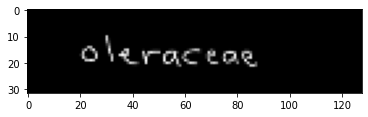



edit distance =  0
original_text =   infralinear
predicted text = infralinear

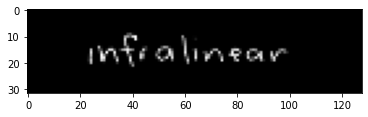



edit distance =  0
original_text =   evanescible
predicted text = evanescible

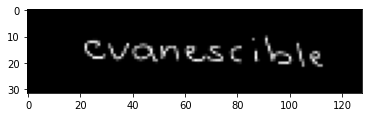



edit distance =  0
original_text =   whiskerage
predicted text = whiskerage

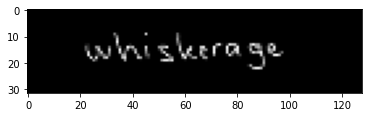



edit distance =  0
original_text =   orchises
predicted text = orchises

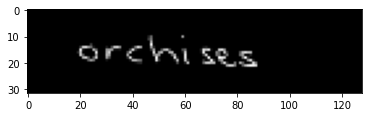



edit distance =  0
original_text =   polyborus
predicted text = polyborus

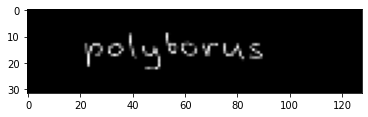



edit distance =  0
original_text =   antenarial
predicted text = antenarial

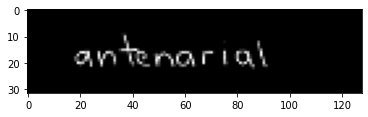



edit distance =  0
original_text =   serphoid
predicted text = serphoid

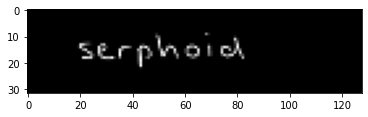



edit distance =  1
original_text =   overcontriteness
predicted text = overcontrliteness

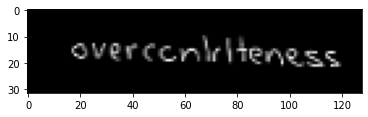



edit distance =  0
original_text =   semnones
predicted text = semnones

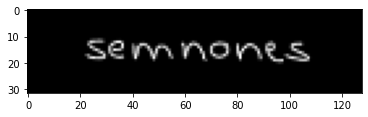



edit distance =  0
original_text =   moonrises
predicted text = moonrises

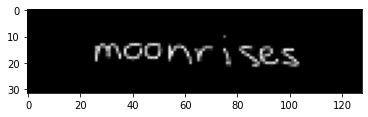



edit distance =  0
original_text =   demobilize
predicted text = demobilize

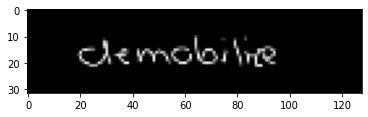



edit distance =  0
original_text =   onlay
predicted text = onlay

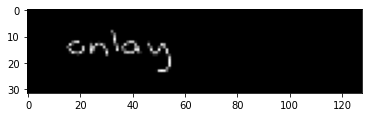



edit distance =  0
original_text =   toolmake
predicted text = toolmake

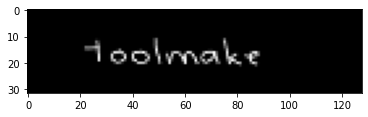



edit distance =  0
original_text =   croissants
predicted text = croissants

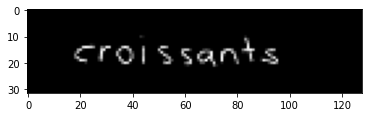



edit distance =  0
original_text =   polycormic
predicted text = polycormic

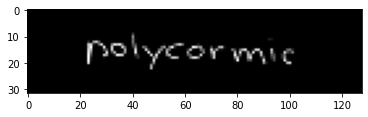



edit distance =  0
original_text =   invinate
predicted text = invinate

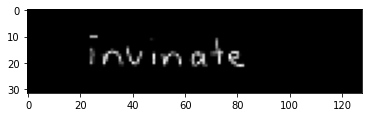



edit distance =  0
original_text =   divisibilities
predicted text = divisibilities

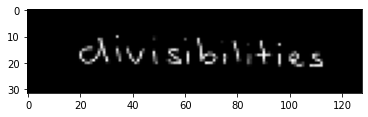



edit distance =  0
original_text =   yachtman
predicted text = yachtman

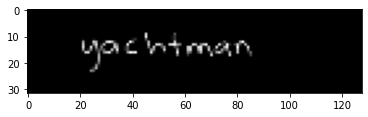



edit distance =  0
original_text =   predivinity
predicted text = predivinity

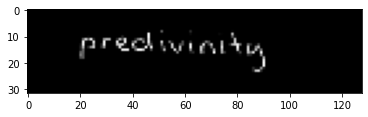



edit distance =  0
original_text =   untransitory
predicted text = untransitory

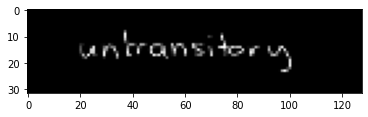

In [ ]:
# use CTC decoder
decoded = K.ctc_decode(prediction, 
                       input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                       greedy=True)[0][0]

out = K.get_value(decoded)

total_character = 0
edit_distance = 0
# see the results (the lower CER the better)
for i, x in enumerate(out):
    original_text = test_original_text[i]
    letters=''    
    for p in x:
        if int(p) != -1:
            letters += CHAR_LIST[int(p)]
            total_character += 1

    edit_cost = levenshtein_distance(original_text, letters)
    edit_distance += edit_cost

    if i % 50 == 0:
        print("edit distance = ", edit_cost)
        print("original_text =  ", original_text)
        print("predicted text = ", end = '')
        for p in x:
            if int(p) != -1:
                print(CHAR_LIST[int(p)], end = '')
        plt.imshow(test_images[i].reshape(32,128), cmap=plt.cm.gray)
        plt.show()
        print('\n')

In [23]:
print("CER: ", edit_distance/total_character)
print("Total edits: ", edit_distance)
print("Total Character: ", total_character)

CER:  0.13690476190476192
Total edits:  184
Total Character:  1344
